---
title: "1. Black-Sholes Model"
author: "Jordan Chong"
date: "2024-02-22"
format:
  html:
    theme: lux          # A clean, professional quantitative theme
    toc: true           # Adds a table of contents on the right
    toc-depth: 3
    number-sections: true
    code-fold: show     # Allows viewers to collapse/expand your Python code!
    code-tools: true
    df-print: paged     # Makes pandas DataFrames look beautiful
execute:
  warning: false        # Hides Python warnings from the final HTML
  echo: true            # Shows your code (crucial for a portfolio)
---

# Option Pricing: Black-Scholes, Heston, and Merton
## Overall Objective: Understand and compare three fundamental option pricing models.

<div style="border-left: 4px solid #2196F3; padding-left: 15px;">
    
**1. Black-Scholes: The benchmark model assuming constant volatility.**  
_Provides a great baseline and is computationally efficient, but assumes constant $\sigma$ which is unrealistic for modern markets._
</div>

<span style="color:gray; opacity: 0.5;">**2. Heston:** Adds stochastic volatility (volatility clustering and mean reversion).</span>  
    <span style="color:gray; opacity: 0.5;">_Captures the "Smirk" or "Skew" via stochastic vol—essential for pricing OTM puts accurately._</span>
    
<span style="color:gray; opacity: 0.5;">**3. Merton Jump:** Adds "jumps" to the asset price to model market shocks.</span>  
    <span style="color:gray; opacity: 0.5;">_Captures "Fat Tails" and sudden crashes via Poisson jumps._</span>


## 1. Black-Scholes Model

The Black-Scholes model assumes the stock price $S_t$ follows a Geometric Brownian Motion (GBM):$$dS_t = \mu S_t dt + \sigma S_t dW_t$$

We can deconstruct this engine into two distinct components:
* **The Deterministic Drift ($\mu S_t dt$):** This represents the expected, constant growth rate of the asset. If market volatility were zero, the stock would simply grow smoothly at rate $\mu$, compounding like money in a standard savings account.
  
* **The Stochastic Diffusion ($\sigma S_t dW_t$):** This injects the randomness. $dW_t$ is a Wiener process (Standard Brownian Motion) representing unpredictable market shocks. By scaling this randomness by the current stock price ($S_t$), the model ensures that the asset price can never drop below zero, perfectly reflecting the reality of limited liability in equities.
Where:   
- $\mu$ is the drift.  
- $\sigma$ is the constant volatility.  
- $dW_t$ is a Wiener process (Brownian motion). 
<br>

**Call Option Formula**  
The price of a European Call option $C(S, t)$ is given by:  
$$C(S, t) = S_0 e^{-qT} N(d_1) - K e^{-rT} N(d_2)$$
<br>
Where $N(\cdot)$ is the cumulative distribution function of the standard normal distribution, and:  
$$d_1 = \frac{\ln(S_0/K) + (r - q + \sigma^2/2)T}{\sigma\sqrt{T}}$$$$d_2 = d_1 - \sigma\sqrt{T}$$  

###
**Volatility Drag (The Asymmetry of Returns):**  
Because asset returns compound geometrically, downward price movements penalize the overall value more severely than upward movements of the exact same percentage. A 50% drop requires a 100% gain just to recover the initial capital. 

Mathematically, this "volatility drag" manifests when we apply Ito's Lemma to the log-return process, introducing a $-\frac{1}{2}\sigma^2$ variance penalty term. The higher the volatility, the stronger this downward drag on the expected geometric return.

## Imports and Setup

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as si
from scipy.integrate import quad
import seaborn as sns

# Set plotting style
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Global Parameters (Toggles)
S0 = 100.0    # Spot Price
K_list = np.linspace(80, 120, 50) # Range of Strikes for plotting
T = 1.0       # Time to Maturity (1 year)
r = 0.05      # Risk-free rate
q = 0.0       # Dividend yield

Loading Options, Spot, Yield, and Dividend Data into memory...
✅ Data Loaded Successfully.
Loaded 352 strikes. S0: 4783.45, r: 0.0537


In [ ]:
from data_loader import MarketDataLoader
from quant_math_engine import heston_call_price, implied_volatility

# Load all massive Parquet files into this notebook's RAM
BASE_DIR = r"G:\My Drive\00) Interview Prep\00) Quant\Data Sources\WRDS Data\Returns\Options"
loader = MarketDataLoader(BASE_DIR)

In [23]:
# 1. Explicitly define your scenario variables so the plotter can see them later
TARGET_DATE = '2024-01-10'
TARGET_EXDATE = '2024-02-16'

# 2. Feed them to the loader to get the exact state
state = loader.get_market_state(TARGET_DATE, TARGET_EXDATE, strike_bound_pct=0.10)

# 3. Extract the variables for the optimizer
S0, T, r, q = state['S0'], state['T'], state['r'], state['q']
market_strikes, market_prices = state['strikes'], state['prices']

print(f"✅ Loaded {len(market_strikes)} strikes. S0: {S0}, r: {r*100:.2f}%")

✅ Loaded 352 strikes. S0: 4783.45, r: 5.37%


## Simulating Black-Scholes
Visualizes the core assumption of the Black-Scholes model: that asset prices follow a log-normal random walk with constant drift and volatility. This Monte Carlo simulation provides a physical intuition for the probability distribution of terminal stock prices.

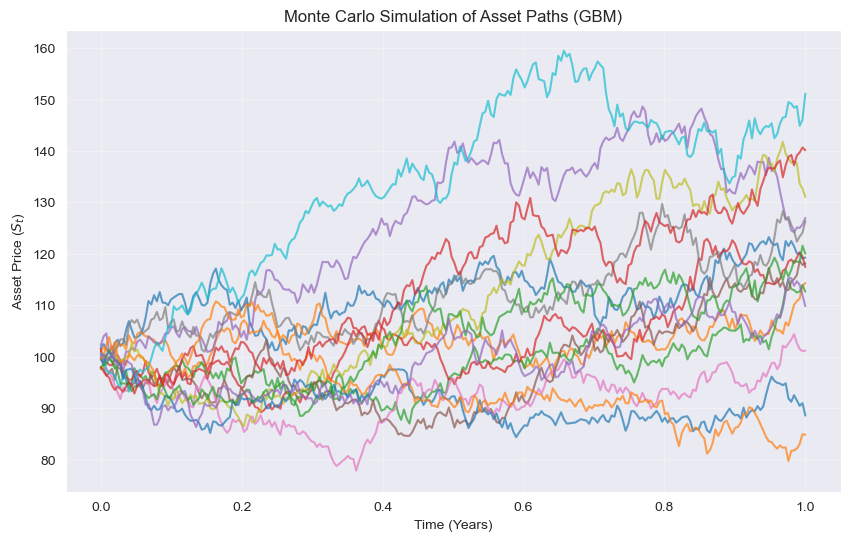

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as si
from mpl_toolkits.mplot3d import Axes3D

# --- 1. Simulate Geometric Brownian Motion (GBM) ---
def simulate_gbm(S0, mu, sigma, T, dt, num_paths):
    """
    Simulates asset price paths using Geometric Brownian Motion.
    """
    N = int(T / dt) # Number of time steps
    t = np.linspace(0, T, N)
    
    # Generate random Wiener process steps
    W = np.random.standard_normal(size=(num_paths, N)) 
    W = np.cumsum(W, axis=1) * np.sqrt(dt) 
    
    # Calculate the paths using the analytical solution to the GBM SDE
    # Notice the volatility drag term: (mu - 0.5 * sigma^2)
    X = (mu - 0.5 * sigma**2) * t + sigma * W 
    S = S0 * np.exp(X) 
    return t, S

# Parameters for simulation
S0_sim = 100      # Initial stock price
mu_sim = 0.08     # Expected return (drift)
sigma_sim = 0.20  # Volatility
T_sim = 1.0       # Time horizon (1 year)
dt_sim = 1/252    # Daily steps
num_paths = 15    # Number of simulated paths to plot

t_steps, paths = simulate_gbm(S0_sim, mu_sim, sigma_sim, T_sim, dt_sim, num_paths)

plt.figure(figsize=(10, 6))
for i in range(num_paths):
    plt.plot(t_steps, paths[i, :], lw=1.5, alpha=0.7)
    
plt.title('Monte Carlo Simulation of Asset Paths (GBM)')
plt.xlabel('Time (Years)')
plt.ylabel('Asset Price ($S_t$)')
plt.grid(True, alpha=0.3)
plt.show()

## 2. Black-Scholes Call Pricing & The Greeks

Implements the closed-form analytical solutions for European Call options. We visualize Delta against the underlying asset price to demonstrate the dynamic, non-linear nature of option sensitivities, introducing the concept of continuous delta-hedging.

Mapping of the "Big Five" Greeks ($\Delta$, $\Gamma$, $\Theta$, $\nu$, $\rho$). By visualizing these simultaneously, we can analyze the multi-dimensional risk exposure of an option contract as the underlying spot price moves across different moneyness levels.

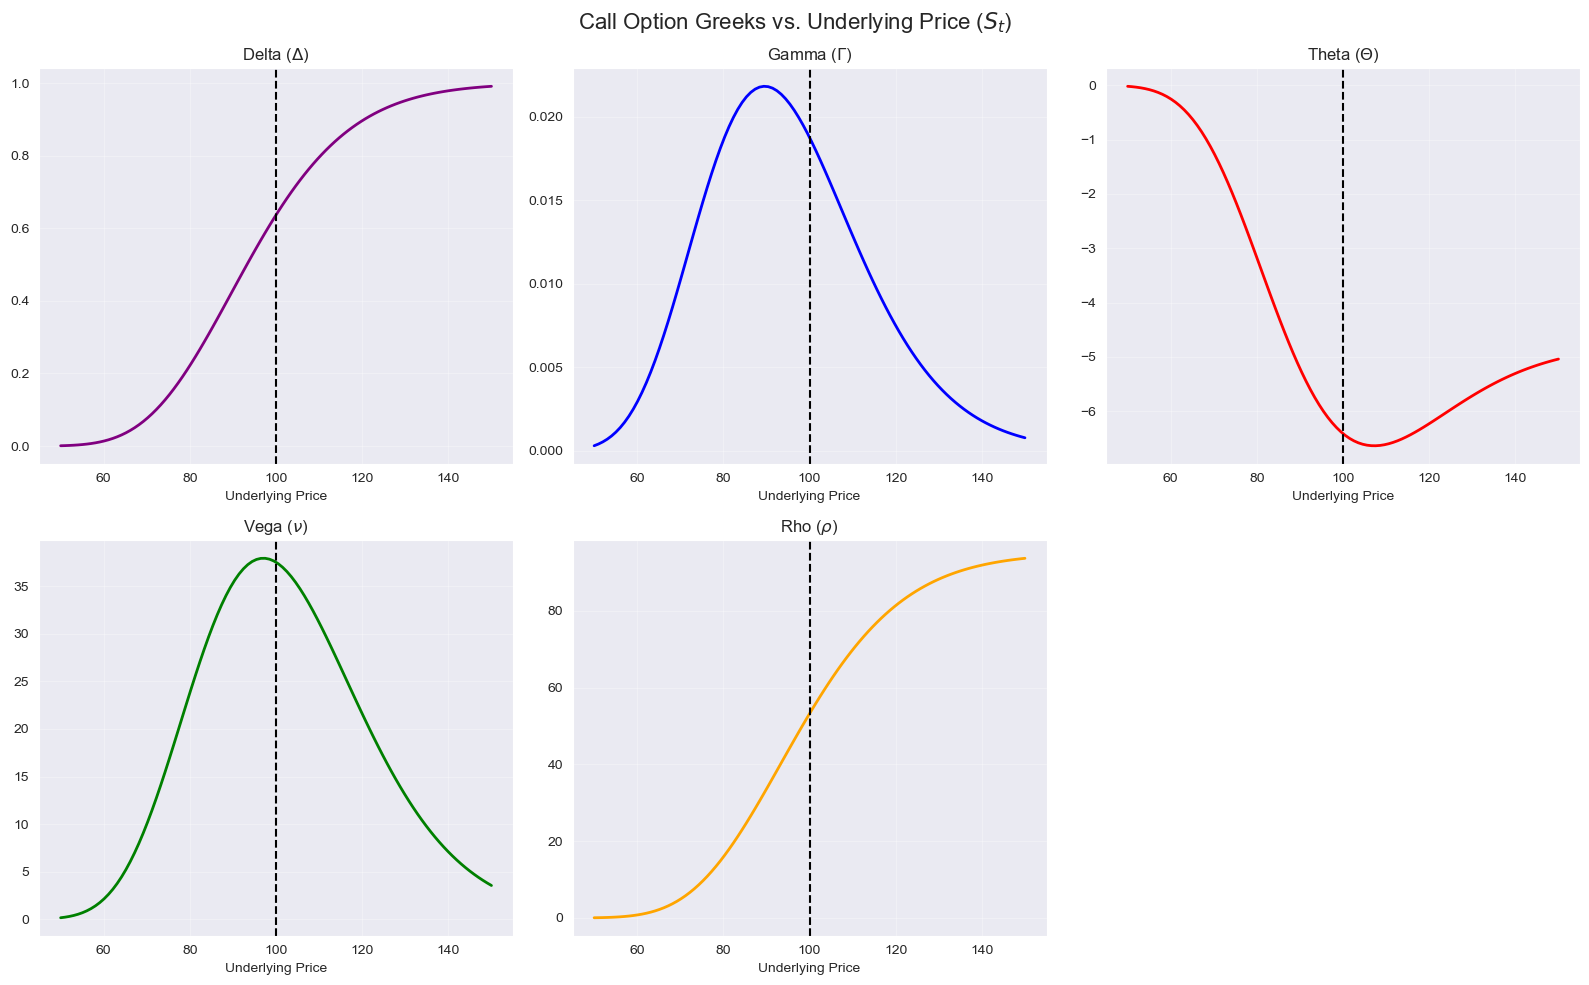

In [17]:

def d1(S, K, T, r, q, sigma):
    return (np.log(S / K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

def d2(S, K, T, r, q, sigma):
    return d1(S, K, T, r, q, sigma) - sigma * np.sqrt(T)

def bs_call_price(S, K, T, r, q, sigma):
    if sigma <= 0 or T <= 0: return max(S * np.exp(-q * T) - K * np.exp(-r * T), 0)
    return (S * np.exp(-q * T) * si.norm.cdf(d1(S, K, T, r, q, sigma)) - 
            K * np.exp(-r * T) * si.norm.cdf(d2(S, K, T, r, q, sigma)))

def bs_call_delta(S, K, T, r, q, sigma):
    """Rate of change of option price with respect to underlying asset."""
    return np.exp(-q * T) * si.norm.cdf(d1(S, K, T, r, q, sigma))

def bs_gamma(S, K, T, r, q, sigma):
    """Rate of change of Delta (convexity). Identical for calls and puts."""
    return (np.exp(-q * T) * si.norm.pdf(d1(S, K, T, r, q, sigma))) / (S * sigma * np.sqrt(T))

def bs_vega(S, K, T, r, q, sigma):
    """Sensitivity to volatility. Identical for calls and puts."""
    return S * np.exp(-q * T) * si.norm.pdf(d1(S, K, T, r, q, sigma)) * np.sqrt(T)

def bs_call_theta(S, K, T, r, q, sigma):
    """Time decay of the option."""
    term1 = -(S * np.exp(-q * T) * si.norm.pdf(d1(S, K, T, r, q, sigma)) * sigma) / (2 * np.sqrt(T))
    term2 = r * K * np.exp(-r * T) * si.norm.cdf(d2(S, K, T, r, q, sigma))
    term3 = q * S * np.exp(-q * T) * si.norm.cdf(d1(S, K, T, r, q, sigma))
    return term1 - term2 + term3

# --- Add Call Rho ---
def bs_call_rho(S, K, T, r, q, sigma):
    """Sensitivity to the risk-free interest rate."""
    return K * T * np.exp(-r * T) * si.norm.cdf(d2(S, K, T, r, q, sigma))

# --- Plotting the Big Five Greeks ---
S_range = np.linspace(50, 150, 100)
K_fixed, T_fixed, r_fixed, q_fixed, sigma_fixed = 100, 1.0, 0.05, 0.0, 0.2

# Calculate Greeks
deltas = [bs_call_delta(S, K_fixed, T_fixed, r_fixed, q_fixed, sigma_fixed) for S in S_range]
gammas = [bs_gamma(S, K_fixed, T_fixed, r_fixed, q_fixed, sigma_fixed) for S in S_range]
thetas = [bs_call_theta(S, K_fixed, T_fixed, r_fixed, q_fixed, sigma_fixed) for S in S_range]
vegas  = [bs_vega(S, K_fixed, T_fixed, r_fixed, q_fixed, sigma_fixed) for S in S_range]
rhos   = [bs_call_rho(S, K_fixed, T_fixed, r_fixed, q_fixed, sigma_fixed) for S in S_range]

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('Call Option Greeks vs. Underlying Price ($S_t$)', fontsize=16)

greeks_data = [
    ('Delta ($\Delta$)', deltas, 'purple'), ('Gamma ($\Gamma$)', gammas, 'blue'), 
    ('Theta ($\Theta$)', thetas, 'red'), ('Vega ($\\nu$)', vegas, 'green'), 
    ('Rho ($\\rho$)', rhos, 'orange')
]

for i, (title, data, color) in enumerate(greeks_data):
    ax = axes[i//3, i%3]
    ax.plot(S_range, data, color=color, lw=2)
    ax.axvline(x=K_fixed, color='black', linestyle='--', label='Strike (K=100)')
    ax.set_title(title)
    ax.set_xlabel('Underlying Price')
    ax.grid(True, alpha=0.3)

axes[1, 2].axis('off') # Hide the empty 6th subplot
plt.tight_layout()
plt.show()

Completes the basic pricing suite by adding European Put options. We run a computational check to validate our formulas against the Put-Call Parity theorem ($C - P = S_0 e^{-qT} - K e^{-rT}$), ensuring our engine respects fundamental no-arbitrage constraints.

In [18]:
# --- Put Option Pricing and Greeks ---
def bs_put_price(S, K, T, r, q, sigma):
    if sigma <= 0 or T <= 0: return max(K * np.exp(-r * T) - S * np.exp(-q * T), 0)
    return (K * np.exp(-r * T) * si.norm.cdf(-d2(S, K, T, r, q, sigma)) - 
            S * np.exp(-q * T) * si.norm.cdf(-d1(S, K, T, r, q, sigma)))

def bs_put_delta(S, K, T, r, q, sigma):
    return -np.exp(-q * T) * si.norm.cdf(-d1(S, K, T, r, q, sigma))

def bs_put_theta(S, K, T, r, q, sigma):
    term1 = -(S * np.exp(-q * T) * si.norm.pdf(d1(S, K, T, r, q, sigma)) * sigma) / (2 * np.sqrt(T))
    term2 = r * K * np.exp(-r * T) * si.norm.cdf(-d2(S, K, T, r, q, sigma))
    term3 = q * S * np.exp(-q * T) * si.norm.cdf(-d1(S, K, T, r, q, sigma))
    return term1 + term2 - term3

def bs_put_rho(S, K, T, r, q, sigma):
    return -K * T * np.exp(-r * T) * si.norm.cdf(-d2(S, K, T, r, q, sigma))

# --- Put-Call Parity Validation ---
C = bs_call_price(S0_sim, K_fixed, T_fixed, r_fixed, q_fixed, sigma_fixed)
P = bs_put_price(S0_sim, K_fixed, T_fixed, r_fixed, q_fixed, sigma_fixed)

lhs = C - P
rhs = S0_sim * np.exp(-q_fixed * T_fixed) - K_fixed * np.exp(-r_fixed * T_fixed)

print(f"Put-Call Parity Check:")
print(f"LHS (Call - Put): {lhs:.4f}")
print(f"RHS (Discounted S - Discounted K): {rhs:.4f}")
print(f"Difference: {abs(lhs - rhs):.1e} (Effectively Zero)")

Put-Call Parity Check:
LHS (Call - Put): 4.8771
RHS (Discounted S - Discounted K): 4.8771
Difference: 0.0e+00 (Effectively Zero)


## 3. The Options Pricing Surface

Options pricing is inherently multi-dimensional. The price is not just a function of the underlying asset's price, but also its strike price and the time remaining until expiration. 

By calculating the Black-Scholes price across a grid of different strikes and maturities, we can generate a 3D pricing surface. This visualizes how Out-Of-The-Money (OTM) options lose value rapidly as expiration approaches, while In-The-Money (ITM) options converge exactly to their intrinsic payoff.

Shifts from 2D static plots to an interactive 3D surface mapping the Call price against both Strike and Time to Maturity. This allows for a deeper geometric understanding of how time decay and moneyness compound together.

In [26]:
import plotly.graph_objects as go
import numpy as np
import scipy.stats as si
import ipywidgets as widgets
from IPython.display import display

# --- 1. Vectorized Black-Scholes Functions ---
def bs_call_price(S, K, T, r, q, vol):
    d1 = (np.log(S / K) + (r - q + 0.5 * vol**2) * T) / (vol * np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    return S * np.exp(-q * T) * si.norm.cdf(d1) - K * np.exp(-r * T) * si.norm.cdf(d2)

def bs_call_delta(S, K, T, r, q, vol):
    d1 = (np.log(S / K) + (r - q + 0.5 * vol**2) * T) / (vol * np.sqrt(T))
    return np.exp(-q * T) * si.norm.cdf(d1)

def bs_gamma(S, K, T, r, q, vol):
    d1 = (np.log(S / K) + (r - q + 0.5 * vol**2) * T) / (vol * np.sqrt(T))
    return (np.exp(-q * T) * si.norm.pdf(d1)) / (S * vol * np.sqrt(T))

# --- 2. Setup Meshgrid ---
T_surf = np.linspace(0.01, 2.0, 50)
K_surf = np.linspace(70, 130, 50)
T_mesh, K_mesh = np.meshgrid(T_surf, K_surf)

S_fixed = 100
q_fixed = 0.0

# --- 3. Initialize FigureWidget ---
fig = go.FigureWidget(data=[
    go.Surface(
        x=K_mesh, 
        y=T_mesh, 
        z=np.zeros_like(T_mesh), # Placeholder
        colorscale='viridis',
        contours={"z": {"show": True, "usecolormap": True, "project_z": True}}
    )
])

# Fixed layout - no overlapping buttons!
fig.update_layout(
    title='Interactive Options Surface',
    scene=dict(xaxis_title='Strike (K)', yaxis_title='Time (T)', zaxis_title='Value'),
    width=900, height=700,
    margin=dict(l=0, r=0, b=0, t=50) 
)

# --- 4. Create UI Controls ---
vol_slider = widgets.FloatSlider(value=0.2, min=0.05, max=1.0, step=0.05, description='Volatility:')
rate_slider = widgets.FloatSlider(value=0.05, min=0.0, max=0.2, step=0.01, description='Rate:')
metric_dropdown = widgets.Dropdown(options=['Call Price', 'Call Delta', 'Gamma'], value='Gamma', description='Metric:')

# --- 5. Update Logic ---
def update_surface(*args):
    vol = vol_slider.value
    rate = rate_slider.value
    metric = metric_dropdown.value
    
    if metric == 'Call Price':
        Z_new = bs_call_price(S_fixed, K_mesh, T_mesh, rate, q_fixed, vol)
    elif metric == 'Call Delta': 
        Z_new = bs_call_delta(S_fixed, K_mesh, T_mesh, rate, q_fixed, vol)
    else:
        Z_new = bs_gamma(S_fixed, K_mesh, T_mesh, rate, q_fixed, vol)
        
    with fig.batch_update():
        fig.data[0].z = Z_new

# Bind controls
vol_slider.observe(update_surface, 'value')
rate_slider.observe(update_surface, 'value')
metric_dropdown.observe(update_surface, 'value')

# Initial render
update_surface()

# --- 6. Display Clean UI ---
controls = widgets.HBox([vol_slider, rate_slider, metric_dropdown])
display(widgets.VBox([controls, fig]))

We use a Brent root-finding algorithm to back-calculate the market's implied volatility from our observed option prices. The resulting plot proves that the Black-Scholes assumption of constant volatility is empirically false—setting up the necessity for the advanced, volatility-skew-aware models in the subsequent notebooks.

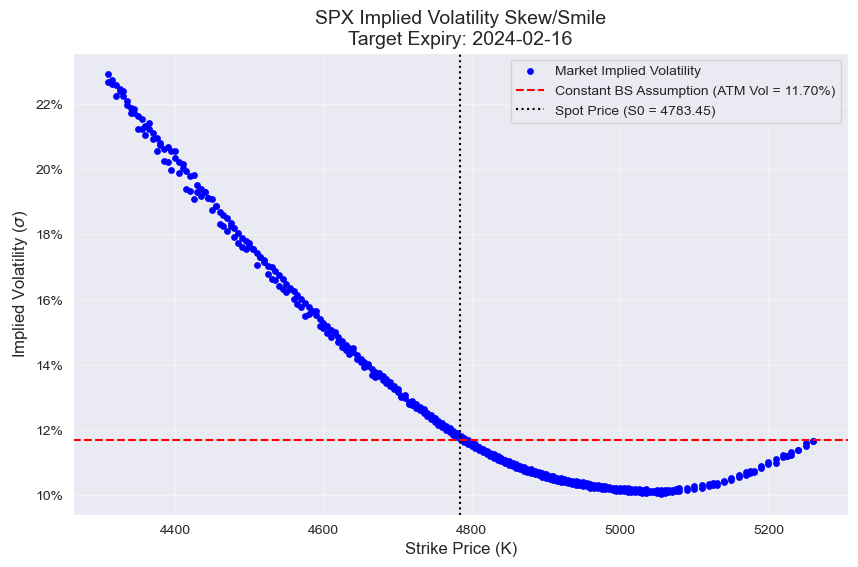

In [24]:
from scipy.optimize import brentq

# --- Implied Volatility Solver ---
def implied_volatility(target_price, S, K, T, r, q, option_type='C'):
    """
    Backs out the implied volatility using Brent's method.
    """
    MAX_VOL = 5.0 # 500% volatility cap for solver limits
    
    def objective_function(sigma):
        if option_type == 'C':
            return bs_call_price(S, K, T, r, q, sigma) - target_price
        else:
            return bs_put_price(S, K, T, r, q, sigma) - target_price

    try:
        # Brent's method requires bounding the root. We search between 1% and 500% vol.
        iv = brentq(objective_function, 1e-4, MAX_VOL)
        return iv
    except ValueError:
        # Fails if the theoretical price cannot match the market price (e.g., arbitrage violations)
        return np.nan

# --- Calculate IV for Market Data ---
market_ivs = []

for K, price in zip(market_strikes, market_prices):
    iv = implied_volatility(price, S0, K, T, r, q, option_type='C')
    market_ivs.append(iv)

market_ivs = np.array(market_ivs)

# Filter out NaNs if any arbitrage violations existed in the raw data
valid_idx = ~np.isnan(market_ivs)
valid_strikes = market_strikes[valid_idx]
valid_ivs = market_ivs[valid_idx]

# Find the At-The-Money (ATM) volatility to act as our "Constant BS Assumption"
atm_idx = np.argmin(np.abs(valid_strikes - S0))
atm_vol = valid_ivs[atm_idx]

# --- Plot the Volatility Skew ---
plt.figure(figsize=(10, 6))
plt.scatter(valid_strikes, valid_ivs, color='blue', label='Market Implied Volatility', s=15)
plt.axhline(y=atm_vol, color='red', linestyle='--', label=f'Constant BS Assumption (ATM Vol = {atm_vol:.2%})')
plt.axvline(x=S0, color='black', linestyle=':', label=f'Spot Price (S0 = {S0:.2f})')

plt.title(f'SPX Implied Volatility Skew/Smile\nTarget Expiry: {TARGET_EXDATE}', fontsize=14)
plt.xlabel('Strike Price (K)', fontsize=12)
plt.ylabel('Implied Volatility ($\sigma$)', fontsize=12)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
plt.legend()
plt.grid(True, alpha=0.4)
plt.show()